<a href="https://colab.research.google.com/github/CardiacModelling/summer-school-2025/blob/main/IonChannelModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Install Myokit, Sundials and import the required modules

In [1]:
# Don't show the installation logs
%%capture
# If installation fails, comment out the line above and run again!

# Install Myokit and Sundials
!apt-get install libsundials-dev
!pip install myokit

# Disable debug messages annoyingly shown on colab
import logging
logging.disable(logging.INFO)

# Import Myokit and matplotlib
import myokit
from matplotlib import pyplot as plt
import numpy as np

### Step 2: Define and plot a voltage clamp protocol

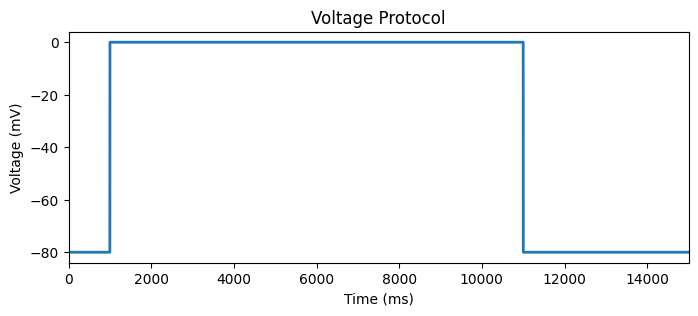

In [38]:
# initialise a Myokit protocol
protocol = myokit.Protocol()

# add three voltage steps
protocol.add_step(-80, 1000) # start at -80mV for 1s
protocol.add_step(0, 10000) # step to 0mV for 10s
protocol.add_step(-80, 4000) # drop back down to -80mV for 4s

# define the time we wish to simulate over
dt = 0.1 # step size
max_time = 15000 # maximum time to simulate over
times = np.arange(0, max_time, dt)

# get the voltages at the defined simulation times
V = protocol.value_at_times(times)

# plot the voltage protocol
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, V, linewidth=2)
ax.set_xlim(0, max_time)
ax.set_title('Voltage Protocol')
ax.set_ylabel('Voltage (mV)')
ax.set_xlabel('Time (ms)')
plt.show()

### Step 3: Define a single Hodgkin-Huxley gate ion channel ODE model and run a simulation

In [17]:
# load in the single HH gate myokit model file
single_gate_model = myokit.load_model("single_gate_HH.mmt")

# initialise myokit simulation with voltage protocol
single_gate_sim = myokit.Simulation(single_gate_model, protocol)

# run simulation and log output
single_gate_log = single_gate_sim.run(max_time, log_times=times)

### Step 4: Plot the simulated Open state probability

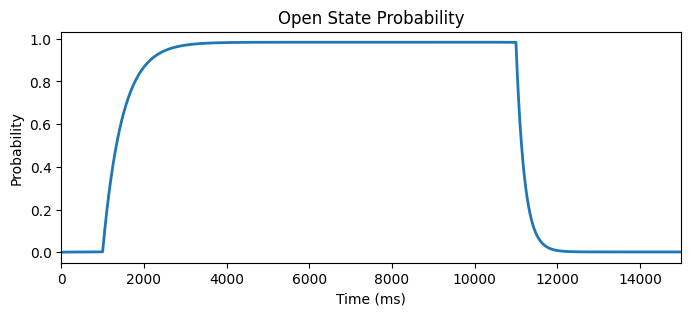

In [40]:
# get logged Open state probability
single_gate_O = np.array(single_gate_log['ikr.O'])

# plot the simulated Open state probability
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, single_gate_O, linewidth=2)
ax.set_xlim(0, max_time)
ax.set_title('Open State Probability')
ax.set_ylabel('Probability')
ax.set_xlabel('Time (ms)')
plt.show()

### Step 5: Calculate and plot the ion channel current


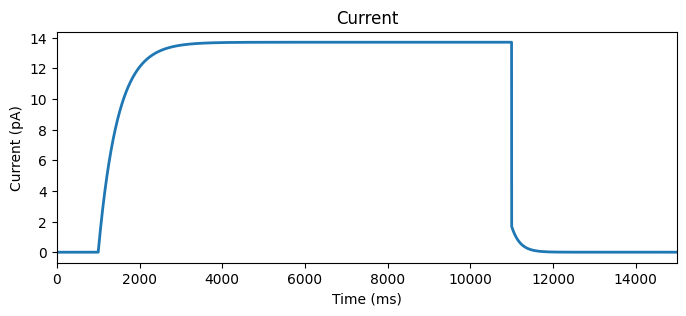

In [46]:
# define channel conductance
g = 0.1524

# calculate Nernst potential
R = 8314 # universal ideal gas constant
T = 298.15 # temperature
F = 96485 # Faraday's constant
ko = 4 # extracellular [K]
ki = 140 # intracellular [K]
E = R * T / F * np.log(ko / ki) # Nernst potential

# calculate current
single_gate_I = g * single_gate_O * (V - E)

# plot current
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, single_gate_I, linewidth=2)
ax.set_xlim(0, max_time)
ax.set_title('Current')
ax.set_ylabel('Current (pA)')
ax.set_xlabel('Time (ms)')
plt.show()

### Step 6: Define a new Hodgkin-Huxley model with two gates and run a simulation

In [43]:
#load in the two HH gate myokit model file
two_gate_model = myokit.load_model("two_gate_HH.mmt")

# initialise myokit simulation with voltage protocol
two_gate_sim = myokit.Simulation(two_gate_model, protocol)

# run simulation and log output
two_gate_log = two_gate_sim.run(max_time, log_times=times)

### Step 7: Plot the simulated Open state probability

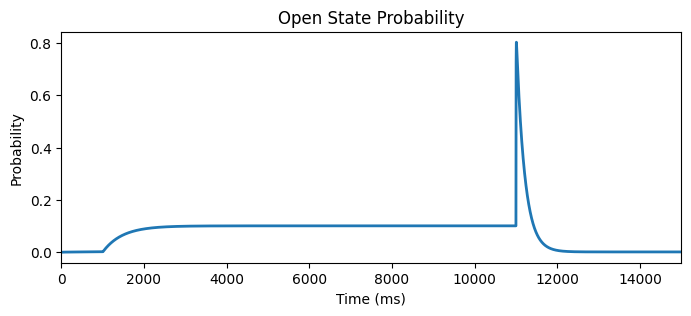

In [47]:
# get logged Open state probability (O1 * O2)
two_gate_O = np.array(two_gate_log['ikr.O1']) * np.array(two_gate_log['ikr.O2'])

# plot the simulated Open state probability
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, two_gate_O, linewidth=2)
ax.set_xlim(0, max_time)
ax.set_title('Open State Probability')
ax.set_ylabel('Probability')
ax.set_xlabel('Time (ms)')
plt.show()

### Step 8: Calculate and plot the ion channel current


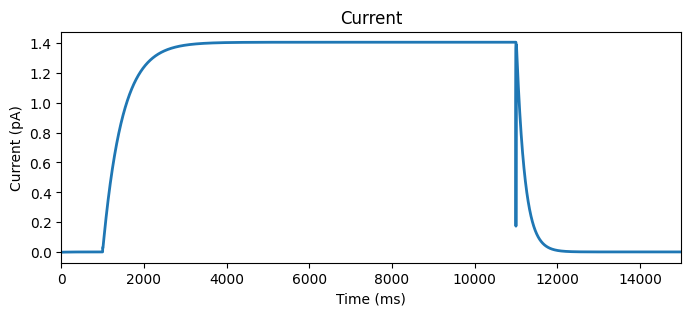

In [48]:
# calculate current
two_gate_I = g * two_gate_O * (V - E)

# plot current
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, two_gate_I, linewidth=2)
ax.set_xlim(0, max_time)
ax.set_title('Current')
ax.set_ylabel('Current (pA)')
ax.set_xlabel('Time (ms)')
plt.show()

### Step 9: Define an equivalent four-state *square* Markov model and run a simulation

In [49]:
# load in the square MM myokit file
square_model = myokit.load_model("square_MM.mmt")

# initialise myokit simulation with voltage protocol
square_sim = myokit.Simulation(square_model, protocol)

# run simulation and log output
square_log = square_sim.run(max_time, log_times=times)

### Step 10: Check that the current in the four-state Markov model matches the current in the two gate Hodgkin-Huxley model

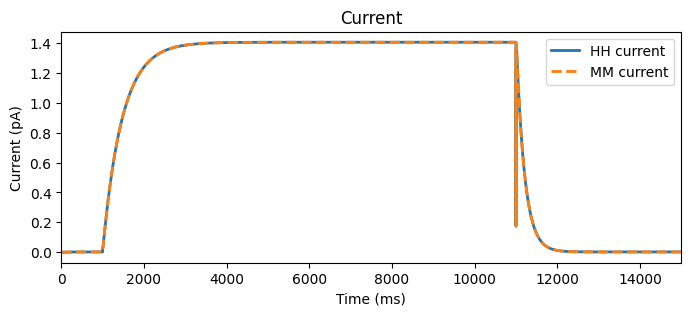

In [50]:
# get logged Open state probability
square_O = np.array(square_log['ikr.O'])

# calculate current
square_I = g * square_O * (V - E)

# plot current
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, two_gate_I, linewidth=2, label = 'HH current')
ax.plot(times, square_I, linestyle = '--', linewidth=2, label = 'MM current')
ax.set_xlim(0, max_time)
ax.set_title('Current')
ax.set_ylabel('Current (pA)')
ax.set_xlabel('Time (ms)')
plt.legend()
plt.show()

### Step 11: Add a drug-binding state to the Markov model

In [57]:
# load in the four-state MM with drug bound state myokit file
drug_bind_model = myokit.load_model("drug_bind_MM.mmt")

# initialise myokit simulation with voltage protocol
drug_bind_sim = myokit.Simulation(drug_bind_model, protocol)

# run simulation with no drug and log output
drug_bind_log_1 = drug_bind_sim.run(max_time, log_times=times)

# reset simulation
drug_bind_sim.reset()

# add drug with 100nM concentration
drug_bind_sim.set_constant('ikr.D', 100)

# run simulation with a drug and log output
drug_bind_log_2 = drug_bind_sim.run(max_time, log_times=times)


### Step 12: Plot current before and after drug added

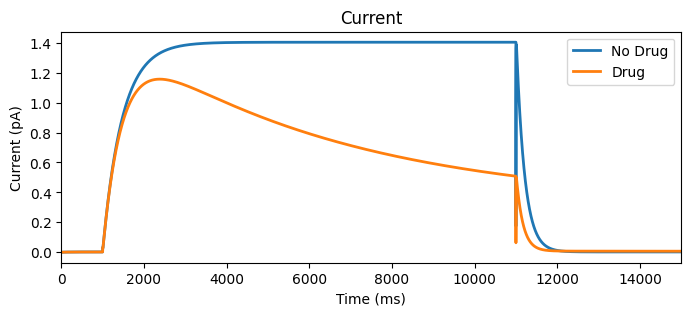

In [58]:
# get logged Open state probability without drug
drug_bind_O_1 = np.array(drug_bind_log_1['ikr.O'])
drug_bind_I_1 = g * drug_bind_O_1 * (V - E)

# get logged Open state probability with drug
drug_bind_O_2 = np.array(drug_bind_log_2['ikr.O'])
drug_bind_I_2 = g * drug_bind_O_2 * (V - E)

# plot
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, drug_bind_I_1, linewidth=2, label = 'No Drug')
ax.plot(times, drug_bind_I_2, linewidth=2, label = 'Drug')
ax.set_xlim(0, max_time)
ax.set_title('Current')
ax.set_ylabel('Current (pA)')
ax.set_xlabel('Time (ms)')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')